<a href="https://colab.research.google.com/github/scottyler89/SynD_BERT/blob/main/SynD_BERT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/scottyler89/SynD_BERT
!bash SynD_BERT/setup.sh

Cloning into 'SynD_BERT'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 11), reused 4 (delta 2), pack-reused 0
Receiving objects: 100% (30/30), 15.85 KiB | 7.92 MiB/s, done.
Resolving deltas: 100% (11/11), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 45.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [21]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from transformers import AutoTokenizer, AutoModel

# Transformer Regressor
class TransformerRegressor(nn.Module):
    def __init__(self, d_model=768, nhead=8, num_layers=8, dim_feedforward=2048):
        super().__init__()
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, 1) # Output a single value

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.fc(output.mean(dim=1))
        return output

# Custom Model combining BERT with Transformer Regressor
class CustomModel(nn.Module):
    def __init__(self, bert_model, max_length=512):
        super().__init__()
        self.bert_model = bert_model
        for param in self.bert_model.parameters(): # Freezing BERT weights
            param.requires_grad = False
        self.max_length = max_length
        self.regressor = TransformerRegressor() # 8-layer transformer regressor

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        #print(outputs)
        # Returns a tuple of 2 tensors, but the first is the hidden state vects
        bert_output = outputs[0]
        padded_output = self.pad_to_fixed_size(bert_output)
        regression_output = self.regressor(padded_output)
        return regression_output

    def pad_to_fixed_size(self, hidden_states):
        batch_size, seq_length, _ = hidden_states.size()
        padded_states = torch.zeros((batch_size, self.max_length, 768), device=hidden_states.device)
        padded_states[:, :seq_length, :] = hidden_states
        return padded_states


# Set up device
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate DNABERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
bert_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True).to(device)

# Create custom model
custom_model = CustomModel(bert_model=bert_model).to(device)


True


Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should prob

In [22]:
# Confirm the bert model is working at all
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGCACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"].to(device)
hidden_states = bert_model(inputs)[0] # [1, sequence_length, 768]
print(hidden_states.shape)

torch.Size([1, 31, 768])


Now load in the data

In [23]:
#############################
import random

def generate_sequence(length=1000):
    return ''.join(random.choice('ACTG') for _ in range(length))

def percentage_of_As(sequence):
    # It's important that the target values are on a resonable range of 0-1
    return sequence.count('ATG') /len(sequence)*30

# Generate synthetic dataset
sequences = [generate_sequence() for _ in range(1000)]
targets = [percentage_of_As(seq) for seq in sequences]

from torch.utils.data import DataLoader, TensorDataset

# Tokenize sequences
inputs = tokenizer(sequences, return_tensors="pt", padding=True, truncation=False).to(device)

# Prepare DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(targets).to(device))
loader = DataLoader(dataset, batch_size=32, shuffle=True)
###############################


In [24]:
from torch.optim import Adam

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = Adam(custom_model.parameters(), lr=3e-5)#0.0001)#3e-5

# Training loop
for epoch in range(10): # Adjust the number of epochs as needed
    for input_ids, attention_mask, target in loader:
        custom_model.zero_grad()
        output = custom_model(input_ids, attention_mask).squeeze()
        loss = loss_function(output, target.float())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")

Epoch 1: Loss = 0.05504752695560455
Epoch 2: Loss = 0.01711471565067768
Epoch 3: Loss = 0.015895934775471687
Epoch 4: Loss = 0.016294021159410477
Epoch 5: Loss = 0.011036563664674759
Epoch 6: Loss = 0.011997183784842491
Epoch 7: Loss = 0.008100999519228935
Epoch 8: Loss = 0.019849691540002823
Epoch 9: Loss = 0.0076523819006979465
Epoch 10: Loss = 0.007568554021418095


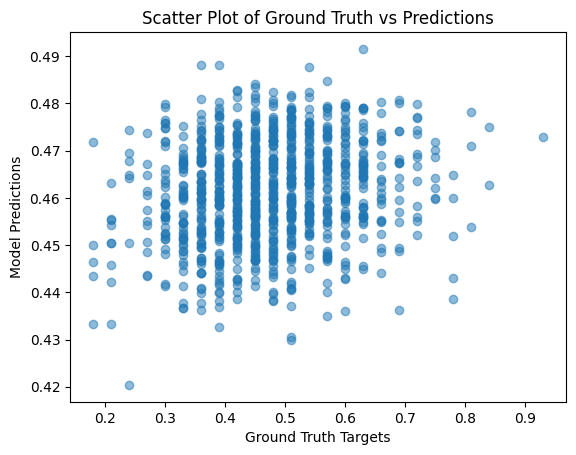

In [25]:
import matplotlib.pyplot as plt

# Collect all predictions and targets
all_predictions = []
all_targets = []

# Evaluate the model
custom_model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for input_ids, attention_mask, target in loader:
        output = custom_model(input_ids, attention_mask).squeeze()
        all_predictions.extend(output.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create the scatter plot
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.xlabel('Ground Truth Targets')
plt.ylabel('Model Predictions')
plt.title('Scatter Plot of Ground Truth vs Predictions')
plt.show()


In [26]:
from scipy.stats import pearsonr
pearsonr(all_targets, all_predictions)

PearsonRResult(statistic=0.17268868713317276, pvalue=3.898225852069049e-08)